# TVLA, DL-LA on AISy Lab data

Datasets are:

1. `aes_tvla.h5` full AES encryption, traces compressed from 220000 to 22000 samples.
2. `aes_tvla_round5.h5` AES round 5, without compression.
3. `aes_tvla_ttables.h5` full AES encryption, without compression.

to read the files, you can use the following code:

In [1]:
import h5py
import numpy as np
import seaborn as sns
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tqdm import tqdm

from src.data.loaders import aisy
from src.data.preprocess.hw import full_states_hw
from src.dlla.hw import dlla_p_gradient, dlla_hw
from src.dlla.preparation import prepare_dlla, labelize
from src.dlla.wegener import make_mlp_wegener, wegener_p_gradient, wegener_performance, wegener_t_test_p_gradient
from src.tools.cache import cache_np
from src.tools.lists import random_divide
from src.tools.plotter import plot_p_gradient, init_plots
from src.tvla.tvla import Tvla

init_plots()

In [2]:
in_file = h5py.File(aisy.aes.tvla_ttables, "r")
TRACES = np.array(in_file['traces_group/traces'], dtype=np.int8)
TVLA_BYTE = in_file['traces_group/metadata']['tvla_byte'].astype(bool)[:, 0]
PLAINTEXT = in_file['traces_group/metadata']['plaintext'].astype(int)
CIPHERTEXT = in_file['traces_group/metadata']['ciphertext'].astype(int)
KEY = in_file['traces_group/metadata']['key'].astype(int)

sns.set_style('whitegrid')

As you can see, you have tvla_byte, which indicates if a trace has low Hamming weight in round 5 (I believe after s-box)
or simply random data. To generate a low HW state in round5, a chosen-plaintext is generated by doing a backpass in AES
encryption. But these are just details, you don't have to worry about it now.

You can split traces into groups A and B (of approx 5k traces each) by considering this tvla_byte.

In [3]:
TRACES.shape

(10000, 22000)

In [4]:
np.min(TRACES), np.max(TRACES)

(-128, 127)

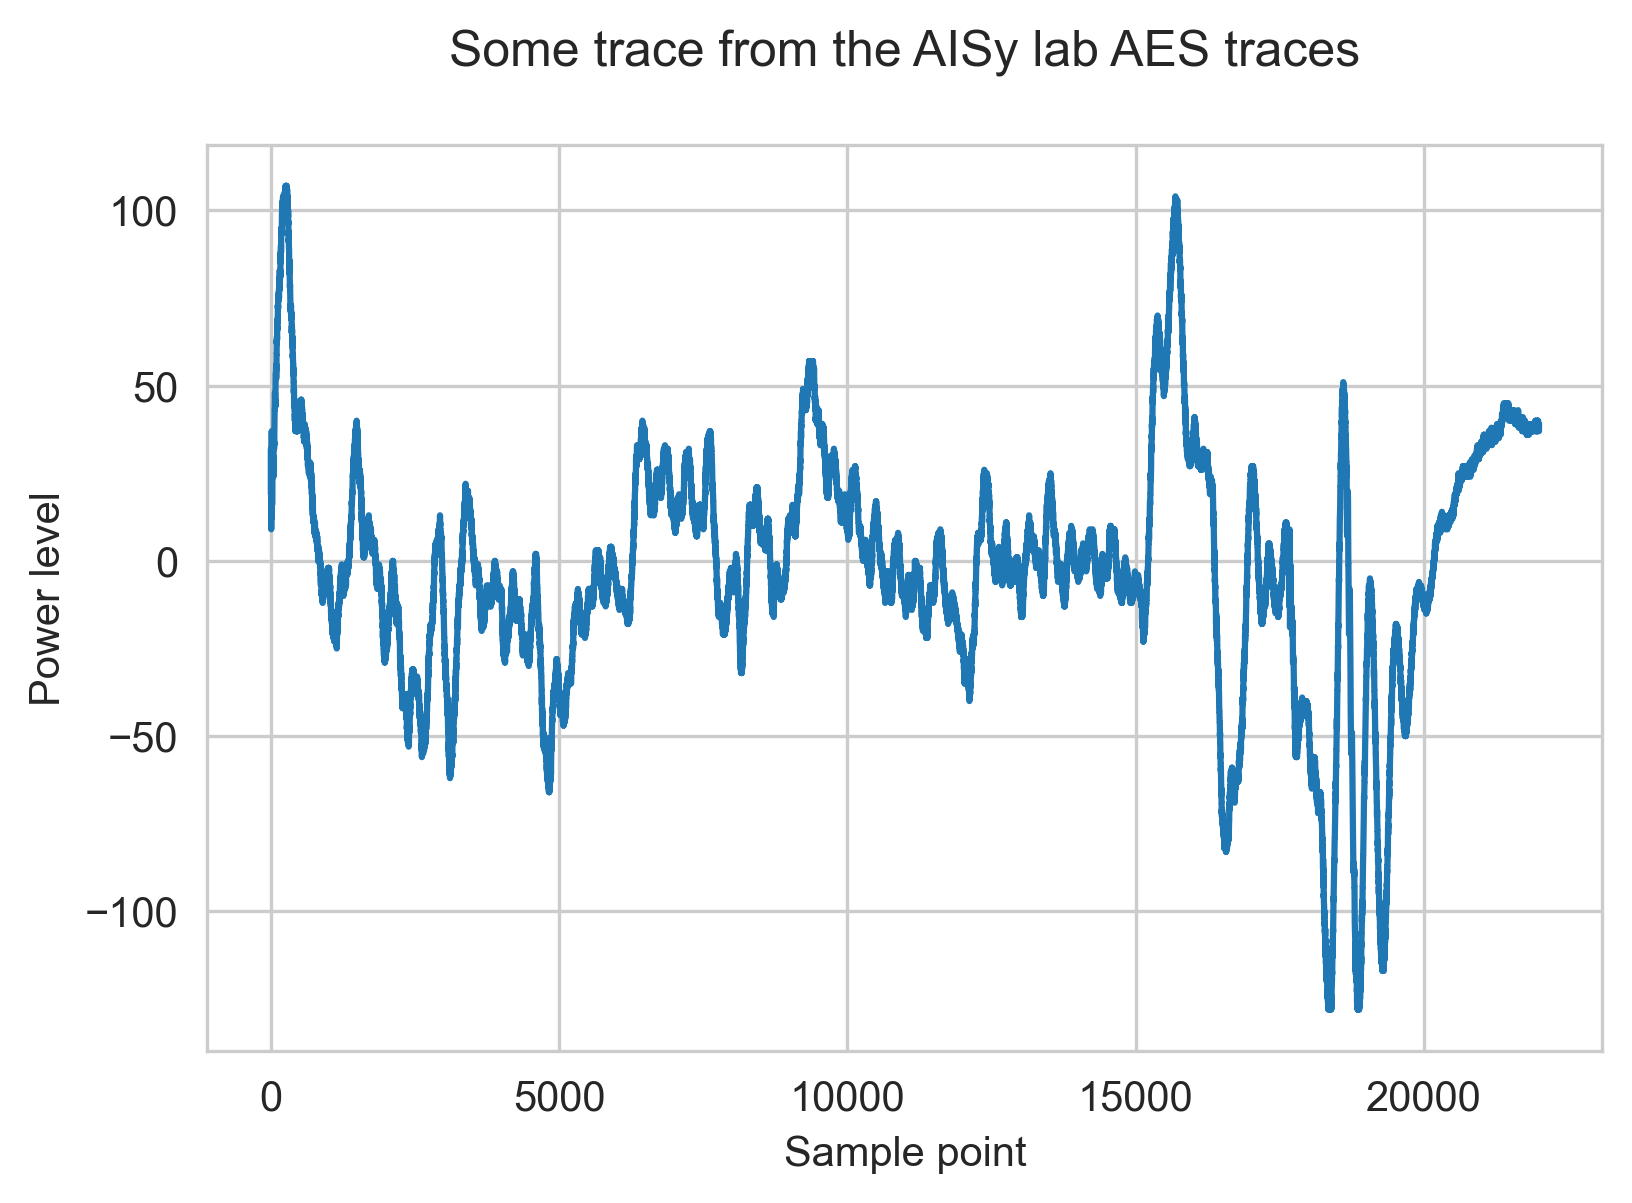

In [5]:
G = sns.lineplot(data=TRACES[0])
G.set(ylabel="Power level", xlabel="Sample point", title="Some trace from the AISy lab AES traces\n") and None

In [6]:
# A: Low HW
A5 = TRACES[TVLA_BYTE]
# B: Random data
B5 = TRACES[np.invert(TVLA_BYTE)]

## $\rho$-test

Pearson correlation

In [ ]:
def calc_t(r: np.array, num_traces: int):
    return r * np.sqrt((num_traces - 2) / (1 - np.power(r, 2)))

In [ ]:
import math

TRACES_HALF = 1000 # math.floor(min(len(A5), len(B5)) / 2)

sns.lineplot(data={
    "Low vs. Random": np.mean(np.corrcoef(A5[:TRACES_HALF].astype(float), B5[:TRACES_HALF].astype(float)), axis=0),
    "Random vs. Random": np.mean(np.corrcoef(B5[:TRACES_HALF].astype(float), B5[TRACES_HALF:2 * TRACES_HALF].astype(float)), axis=0)
})

In [ ]:
R_AB = np.array([np.corrcoef(A5[:TRACES_HALF, i], B5[:TRACES_HALF, i])[1,0] for i in range(A5.shape[1])])
R_BB = np.array([np.corrcoef(A5[:TRACES_HALF, i], A5[TRACES_HALF:TRACES_HALF * 2, i])[1,0] for i in range(A5.shape[1])])

sns.lineplot(data={
    "Low vs. Random": R_AB,
    "Random vs. Random": R_BB
})

In [ ]:
from scipy.stats import norm

# The k cross-validation results ˆr(j)(τ) can then be averaged in order to get a single(unbiased) result ˆr(τ)

def fishers_z(r: np.array):
    return .5 * np.log((1 + r) / (1 - r))

def p_value_r(r: np.array):
    return 2 * (1 - norm.cdf(np.abs(fishers_z(r))))

PR_AB = p_value_r(R_AB)
PR_BB = p_value_r(R_BB)

G = sns.lineplot(data={
    "Low vs. Random": p_value_r(PR_AB),
    "Random vs. Random": p_value_r(PR_BB)
})
G.set(yscale="log", ylim=(10 ** -16, 1))
G.invert_yaxis()

## TVLA

With 2 class evaluation. Method of the DL-LA paper.

In [7]:
def mdiff(a, b):
    """
    Calculates the moment difference for all sample points,
    a predictive measure for the performance of an 1st order t-test.
    """
    def get_moment(x: np.array):
        return x.mean(axis=0, dtype=np.float128)

    a1, a2 = random_divide(a)
    _, b2 = random_divide(b)

    mdiff_in = np.abs(get_moment(a1) - get_moment(a2))
    mdiff_out = np.abs(get_moment(a1) - get_moment(b2))

    return mdiff_out - mdiff_in

MDIFF = mdiff(A5, B5)

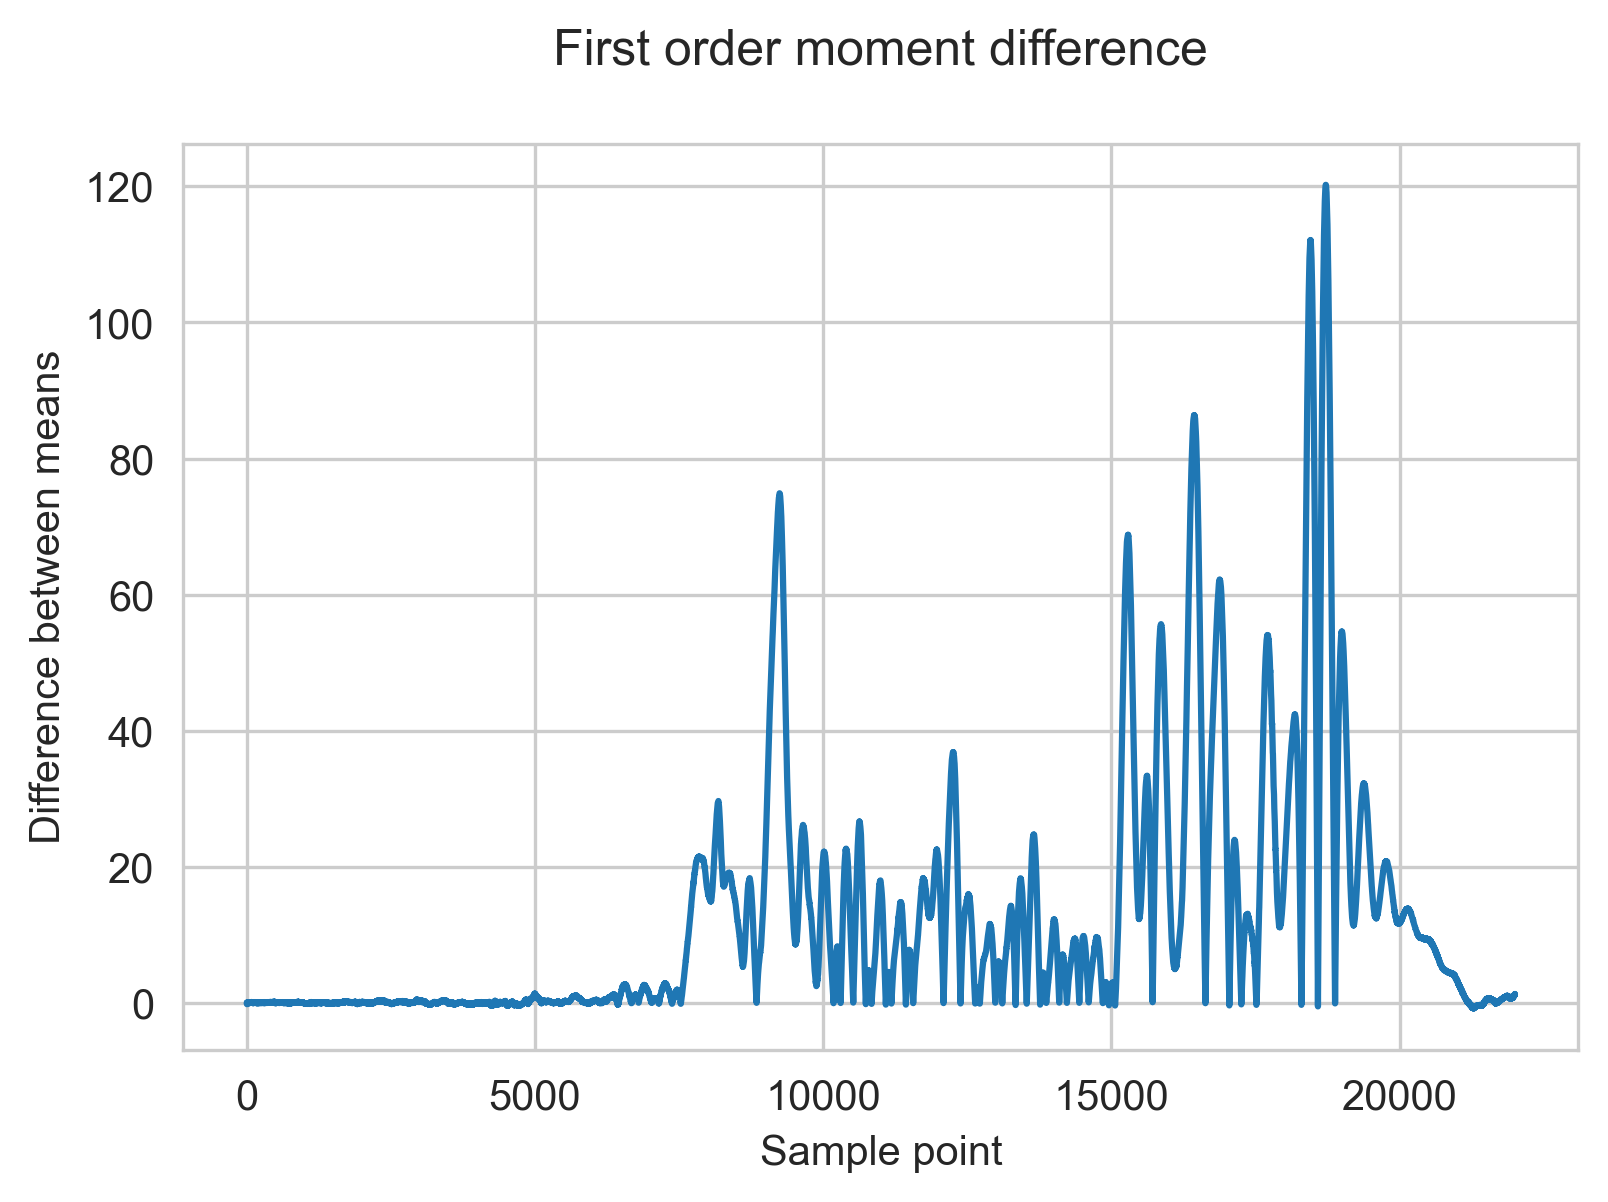

In [8]:

G = sns.lineplot(data=MDIFF)
G.set(ylabel="Difference between means", xlabel="Sample point", title="First order moment difference\n") and None

In [9]:
TITLE = "A: Low hamming weight, B: Random\n"
MAX_TRACES = 100

def min_p_gradient(a, b):
    """
    Calculates the min p-gradient for the t-test of two data sets.
    """
    trace_length = a.shape[1]
    accumulator = Tvla(trace_length, max_order=3)
    accumulator.add(a, b)

    return np.array(accumulator.min_p_gradient)

Computing min-p gradients: 100%|██████████| 3/3 [00:00<00:00, 11.20it/s]


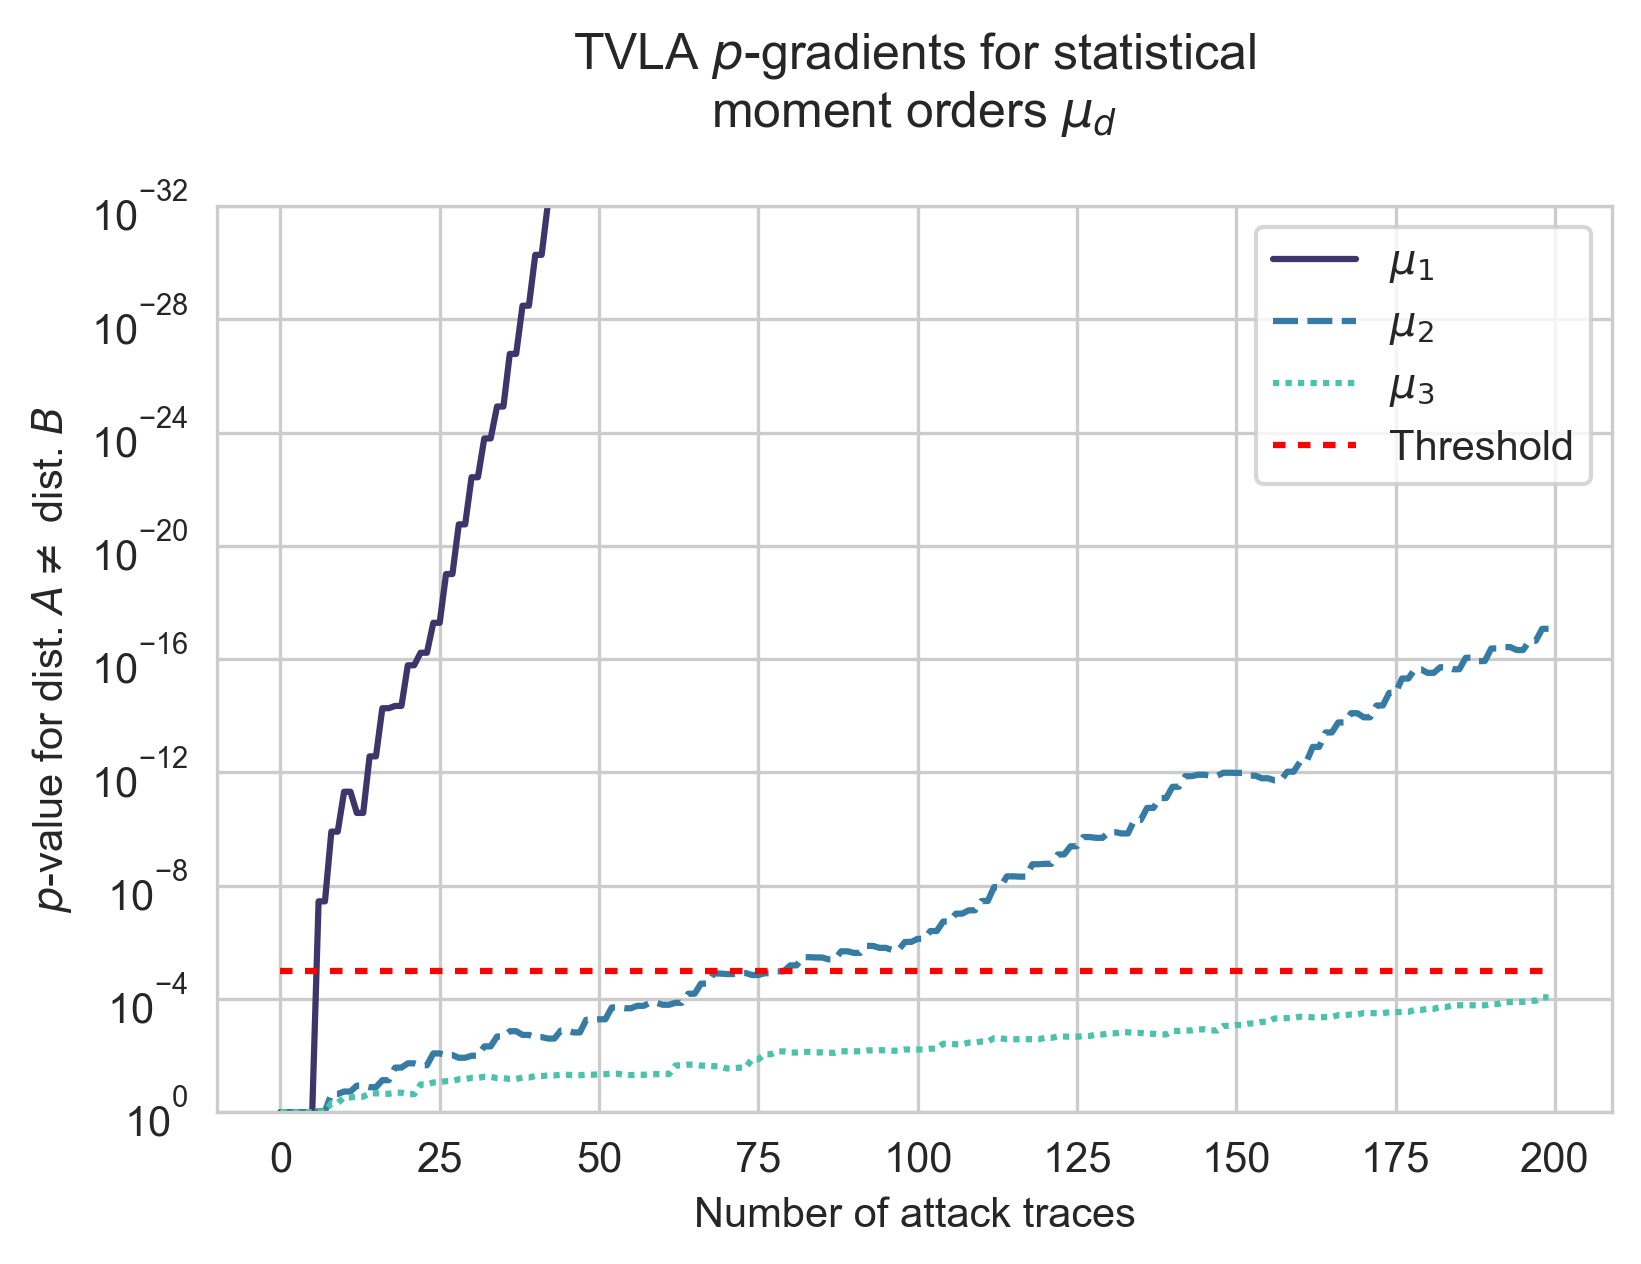

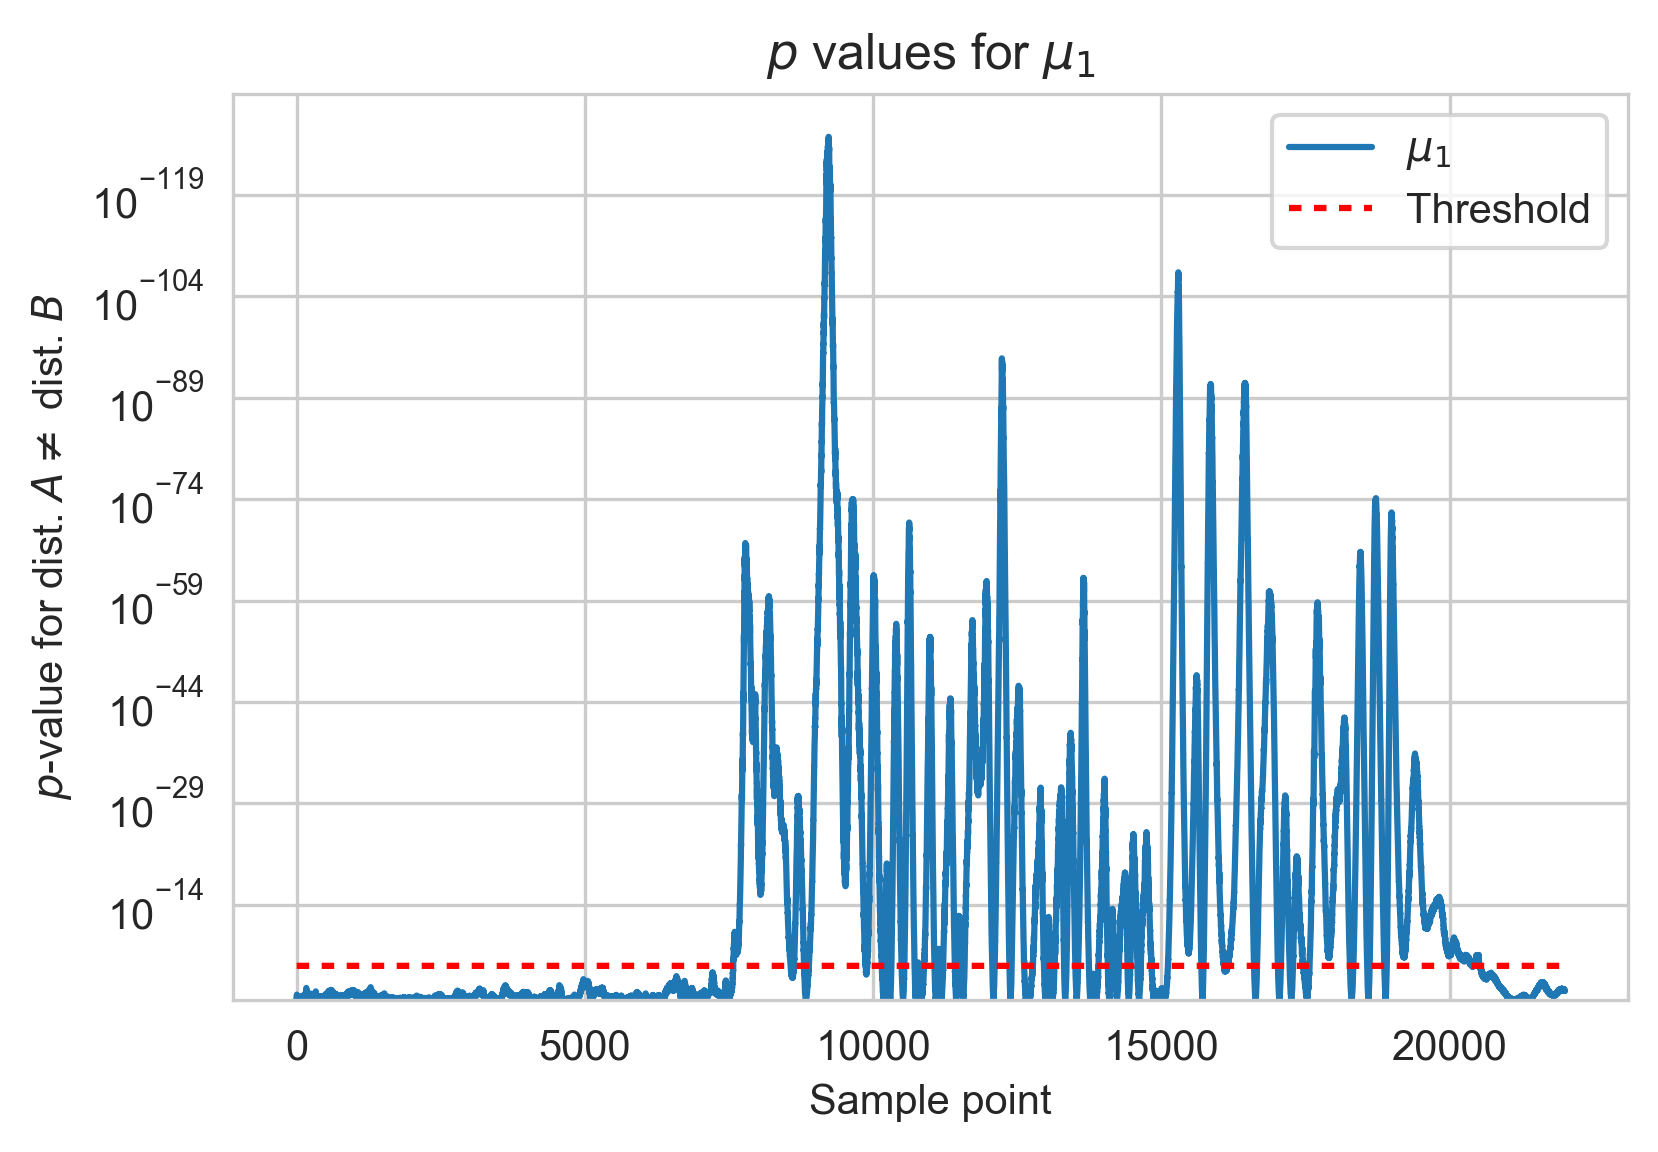

<AxesSubplot:title={'center':'$p$ values for $\\mu_{1}$'}, xlabel='Sample point', ylabel='$p$-value for dist. $A \\neq$ dist. $B$'>

In [10]:
TRACE_LEN = A5.shape[1]

ACC_AB = Tvla(TRACE_LEN, max_order=3)
ACC_BB = Tvla(TRACE_LEN, max_order=3)

ACC_AB.add(A5[:MAX_TRACES], B5[:MAX_TRACES])
ACC_BB.add(*random_divide(B5[:int(MAX_TRACES * 2.5)]))

ACC_AB.plot_gradients()
ACC_AB.plot_p_values(1)

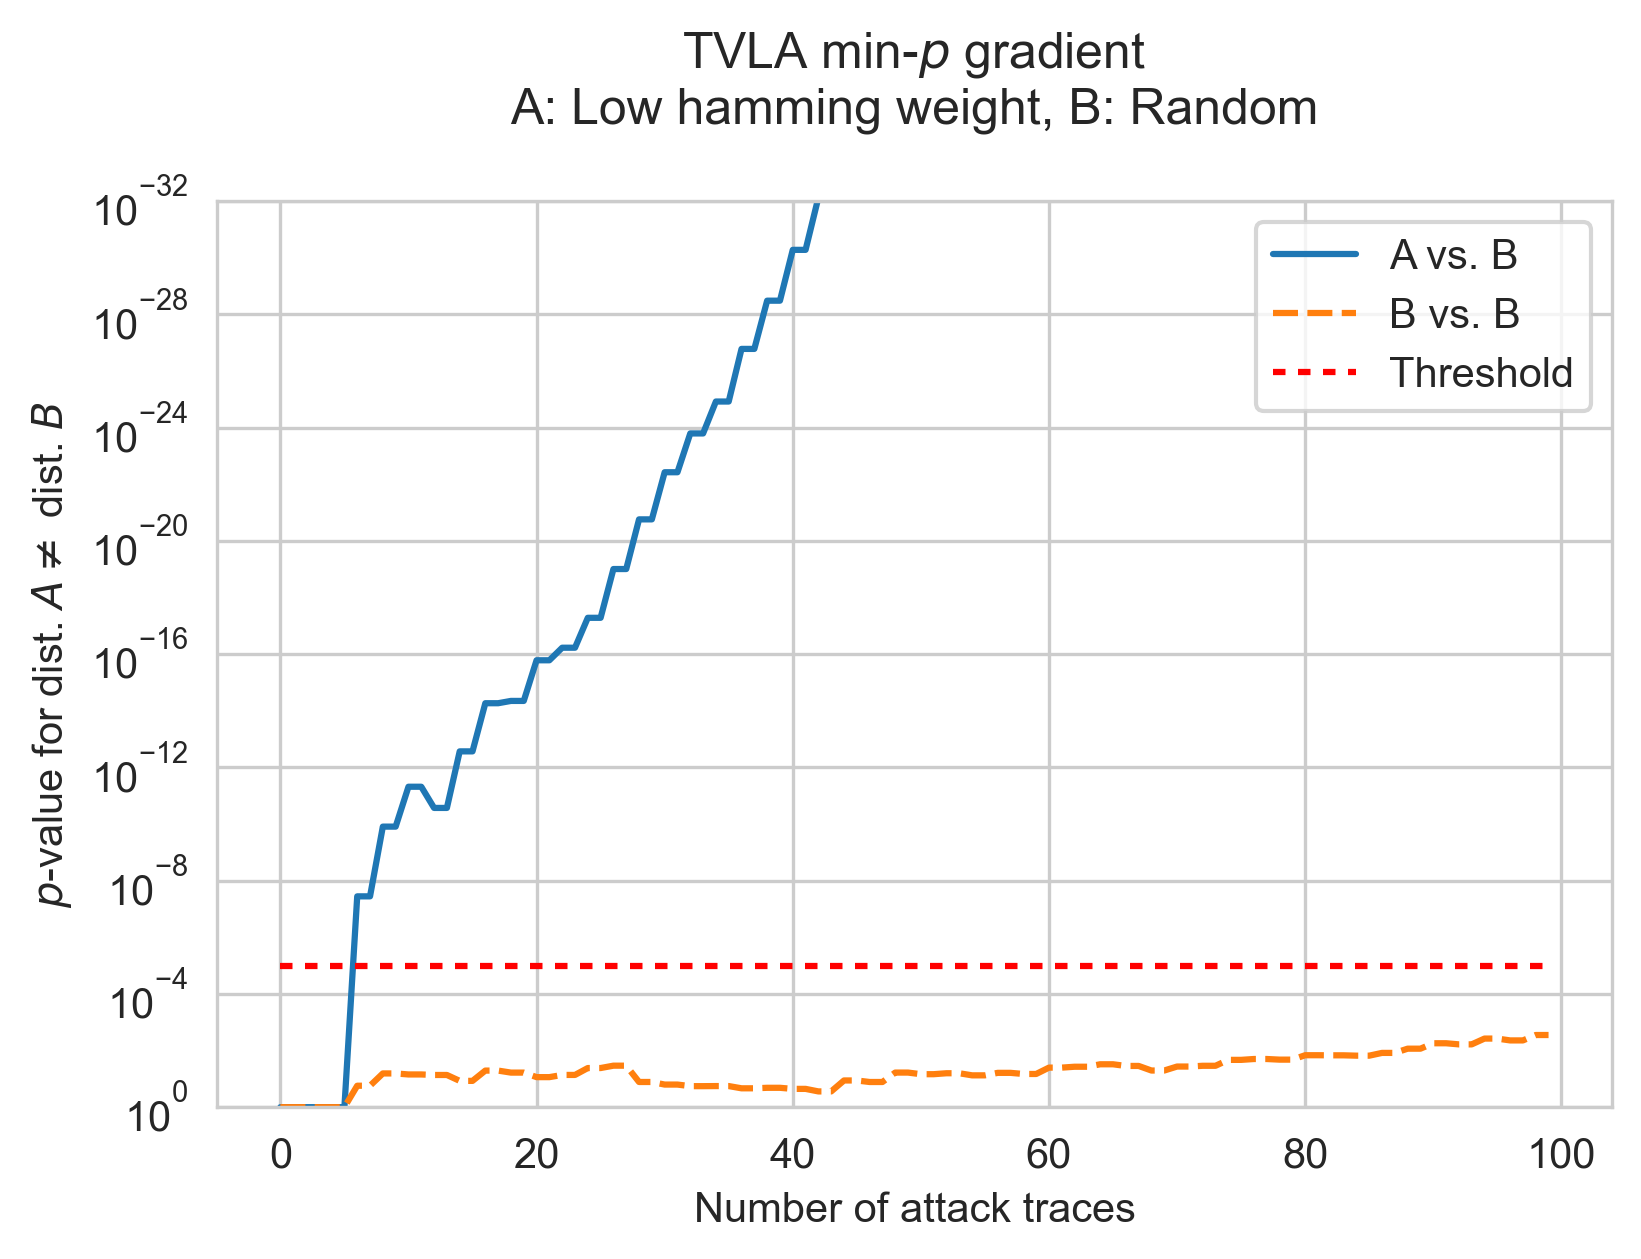

In [11]:
ORDER = 1
plot_p_gradient({"A vs. B": ACC_AB.p_gradient(1), "B vs. B": ACC_BB.p_gradient(1)}, f"TVLA min-$p$ gradient\n{TITLE}", MAX_TRACES)

## 2-class training

With 2 class evaluation

In [12]:
AB_DLLA_WEGENER = prepare_dlla(*labelize((A5, B5)))
MDL_WEGENER_AB = make_mlp_wegener(*AB_DLLA_WEGENER[:2])

Epoch 1/5
54/54 [==============================] - 1s 14ms/step - loss: 0.0068 - accuracy: 0.9885

In [13]:
BB_DLLA_WEGENER = prepare_dlla(*labelize(random_divide(B5)))
MDL_WEGENER_BB = make_mlp_wegener(*BB_DLLA_WEGENER[:2])

Epoch 1/5
27/27 [==============================] - 1s 15ms/step - loss: 0.2782 - accuracy: 0.4927
Epoch 2/5
27/27 [==============================] - 0s 13ms/step - loss: 0.2281 - accuracy: 0.6268

In [14]:
AB_PG_WEGENER = wegener_p_gradient(MDL_WEGENER_AB, *AB_DLLA_WEGENER[2:])
BB_PG_WEGENER = wegener_p_gradient(MDL_WEGENER_BB, *BB_DLLA_WEGENER[2:])

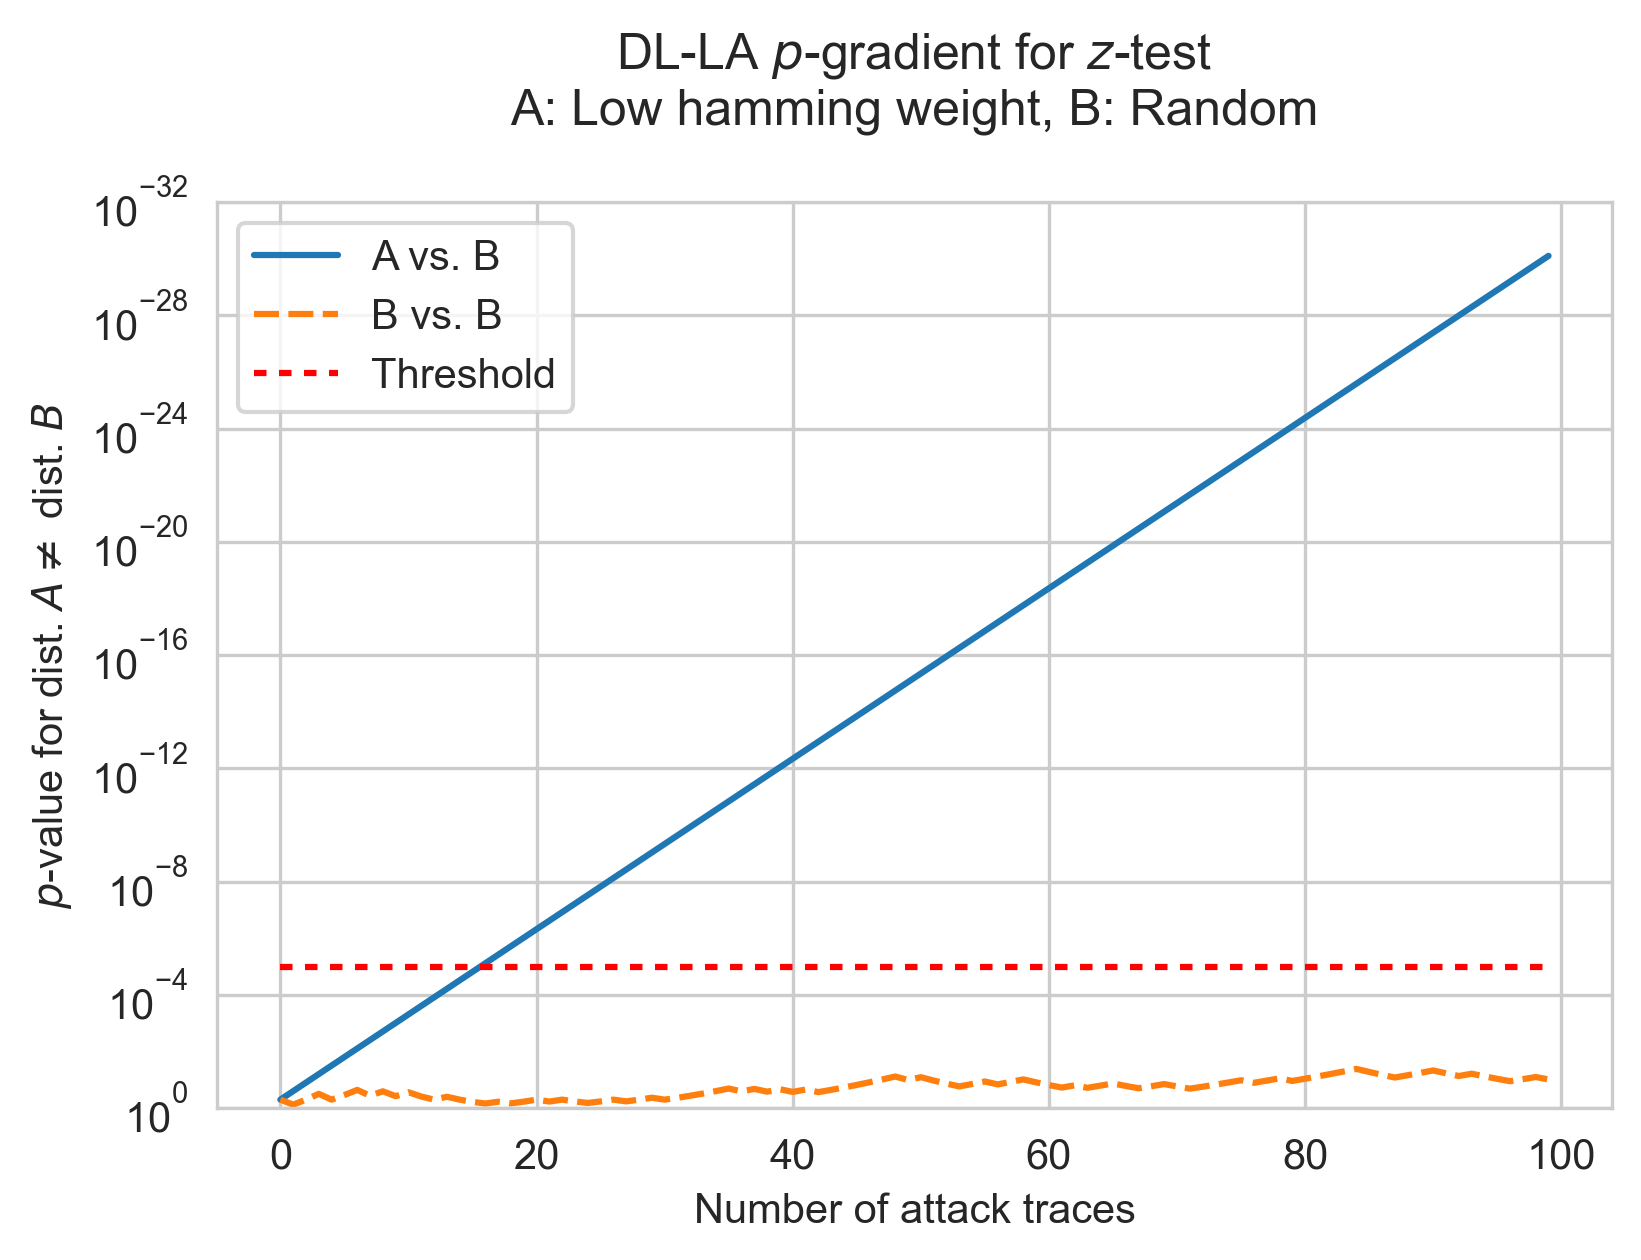

In [15]:
plot_p_gradient({"A vs. B": AB_PG_WEGENER, "B vs. B": BB_PG_WEGENER}, f"DL-LA $p$-gradient for $z$-test\n{TITLE}", MAX_TRACES)

## 9-class training

With 2 class evaluation

100%|██████████| 10000/10000 [00:02<00:00, 3415.04it/s]


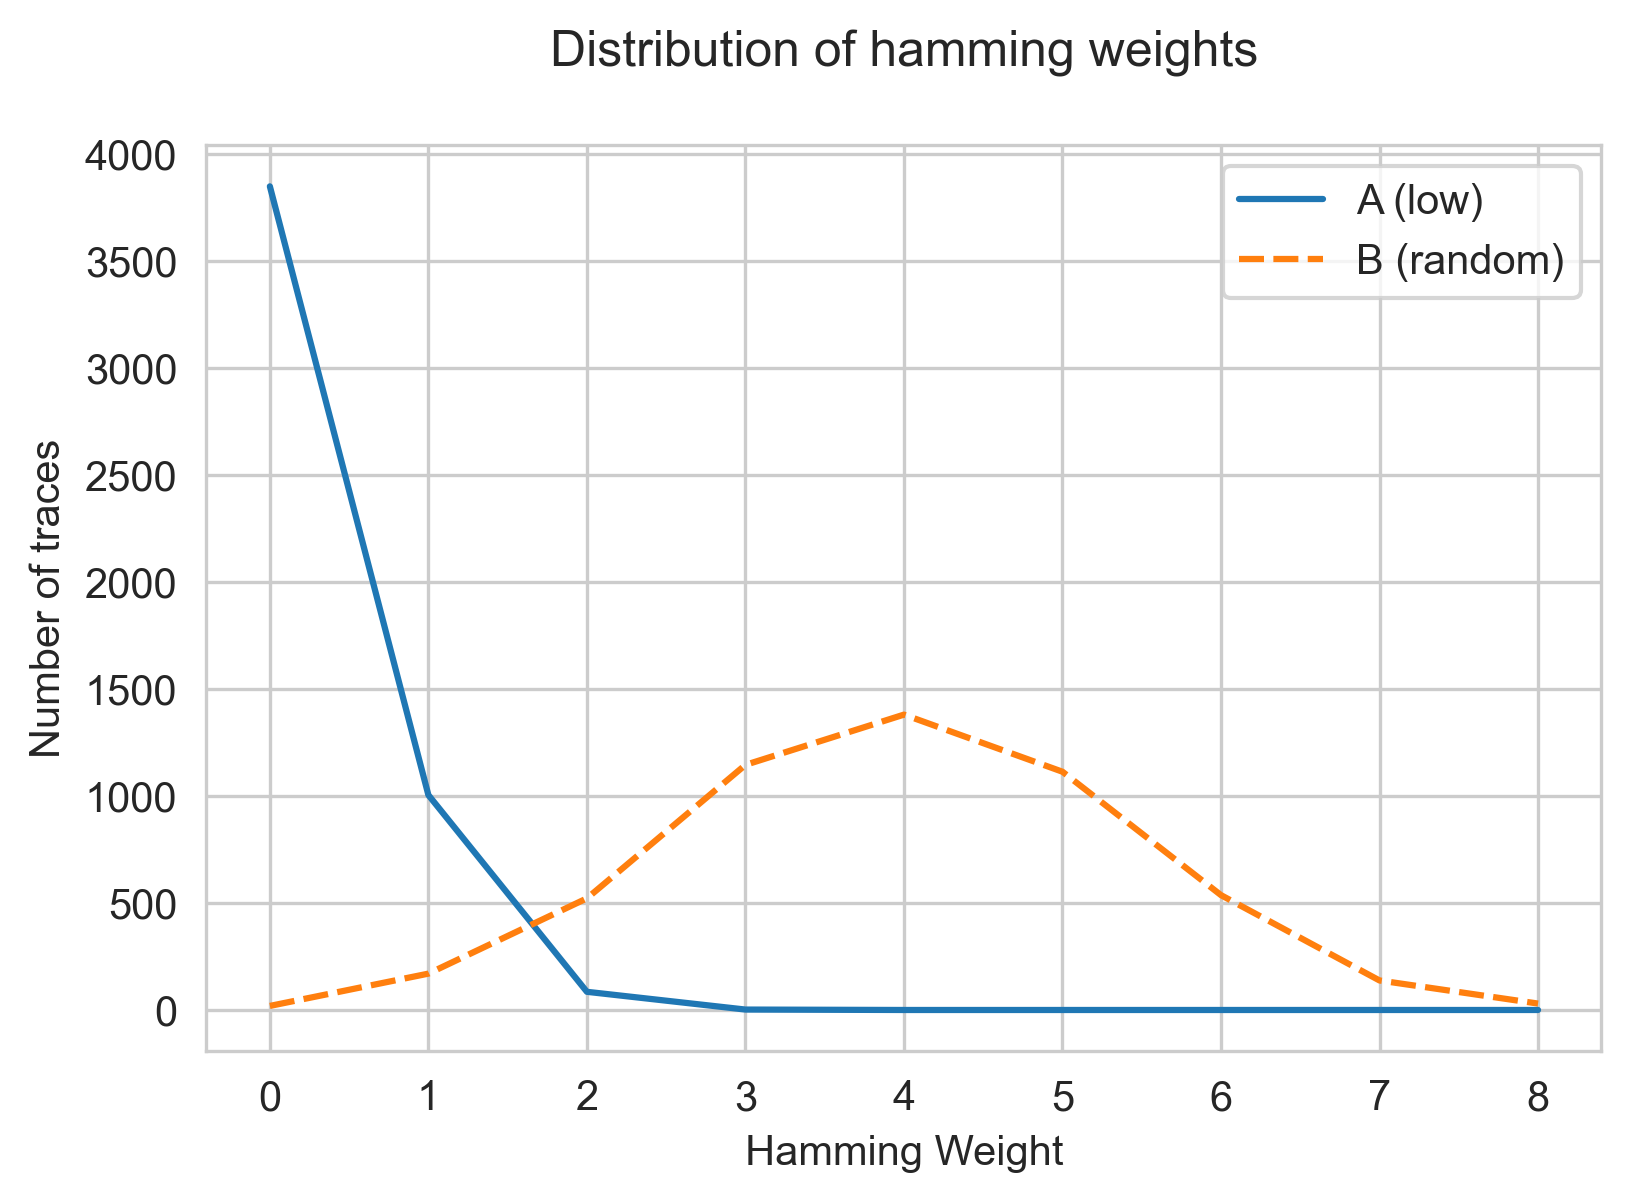

In [16]:
def hw_byte(plaintexts: np.array, keys: np.array, aes_round=4, target_byte=0):
    """
    Returns the hamming weight of the AES state at the given round and target byte indices.
    """
    states = full_states_hw(plaintexts, keys)

    return states[:, aes_round, target_byte]

HAMMING_WEIGHTS = hw_byte(PLAINTEXT, KEY)

G = sns.lineplot(data={
    "A (low)": np.bincount(HAMMING_WEIGHTS[TVLA_BYTE], minlength=9),
    "B (random)": np.bincount(HAMMING_WEIGHTS[np.invert(TVLA_BYTE)], minlength=9)
})
G.set(title="Distribution of hamming weights\n", xlabel="Hamming Weight", ylabel="Number of traces") and None

In [17]:
def prepare_dlla_9cls(traces, hamming_weights):
    """
    Prepares traces for usage in 9 class training.
    """
    ab = prepare_dlla(traces, hamming_weights, 9)

    hws_random = hamming_weights.copy()
    np.random.shuffle(hws_random)
    bb = prepare_dlla(traces, hws_random, 9)

    return ab, bb

AB_DLLA, BB_DLLA = prepare_dlla_9cls(TRACES, HAMMING_WEIGHTS)

In [18]:
def make_mlp(x, y):
    mdl = Sequential()
    mdl.add(Dense(100, activation='relu', input_shape=(TRACE_LEN,)))
    mdl.add(Dense(100, activation='relu'))
    mdl.add(Dense(100, activation='relu'))
    mdl.add(Dense(100, activation='relu'))
    mdl.add(Dense(9, activation='softmax'))

    mdl.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics='accuracy')

    mdl.fit(x, y, shuffle=True, batch_size=150, epochs=1, verbose=True)

    return mdl

In [19]:
MODEL_AB = make_mlp(*AB_DLLA[:2])
MODEL_BB = make_mlp(*BB_DLLA[:2])

/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


54/54 [==============================] - 1s 13ms/step - loss: 1.8652 - accuracy: 0.3633

In [20]:
dlla_hw(MODEL_AB, *AB_DLLA[2:])

AB_PG = dlla_p_gradient(MODEL_AB, *AB_DLLA[2:])
BB_PG = dlla_p_gradient(MODEL_BB, *BB_DLLA[2:])

/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


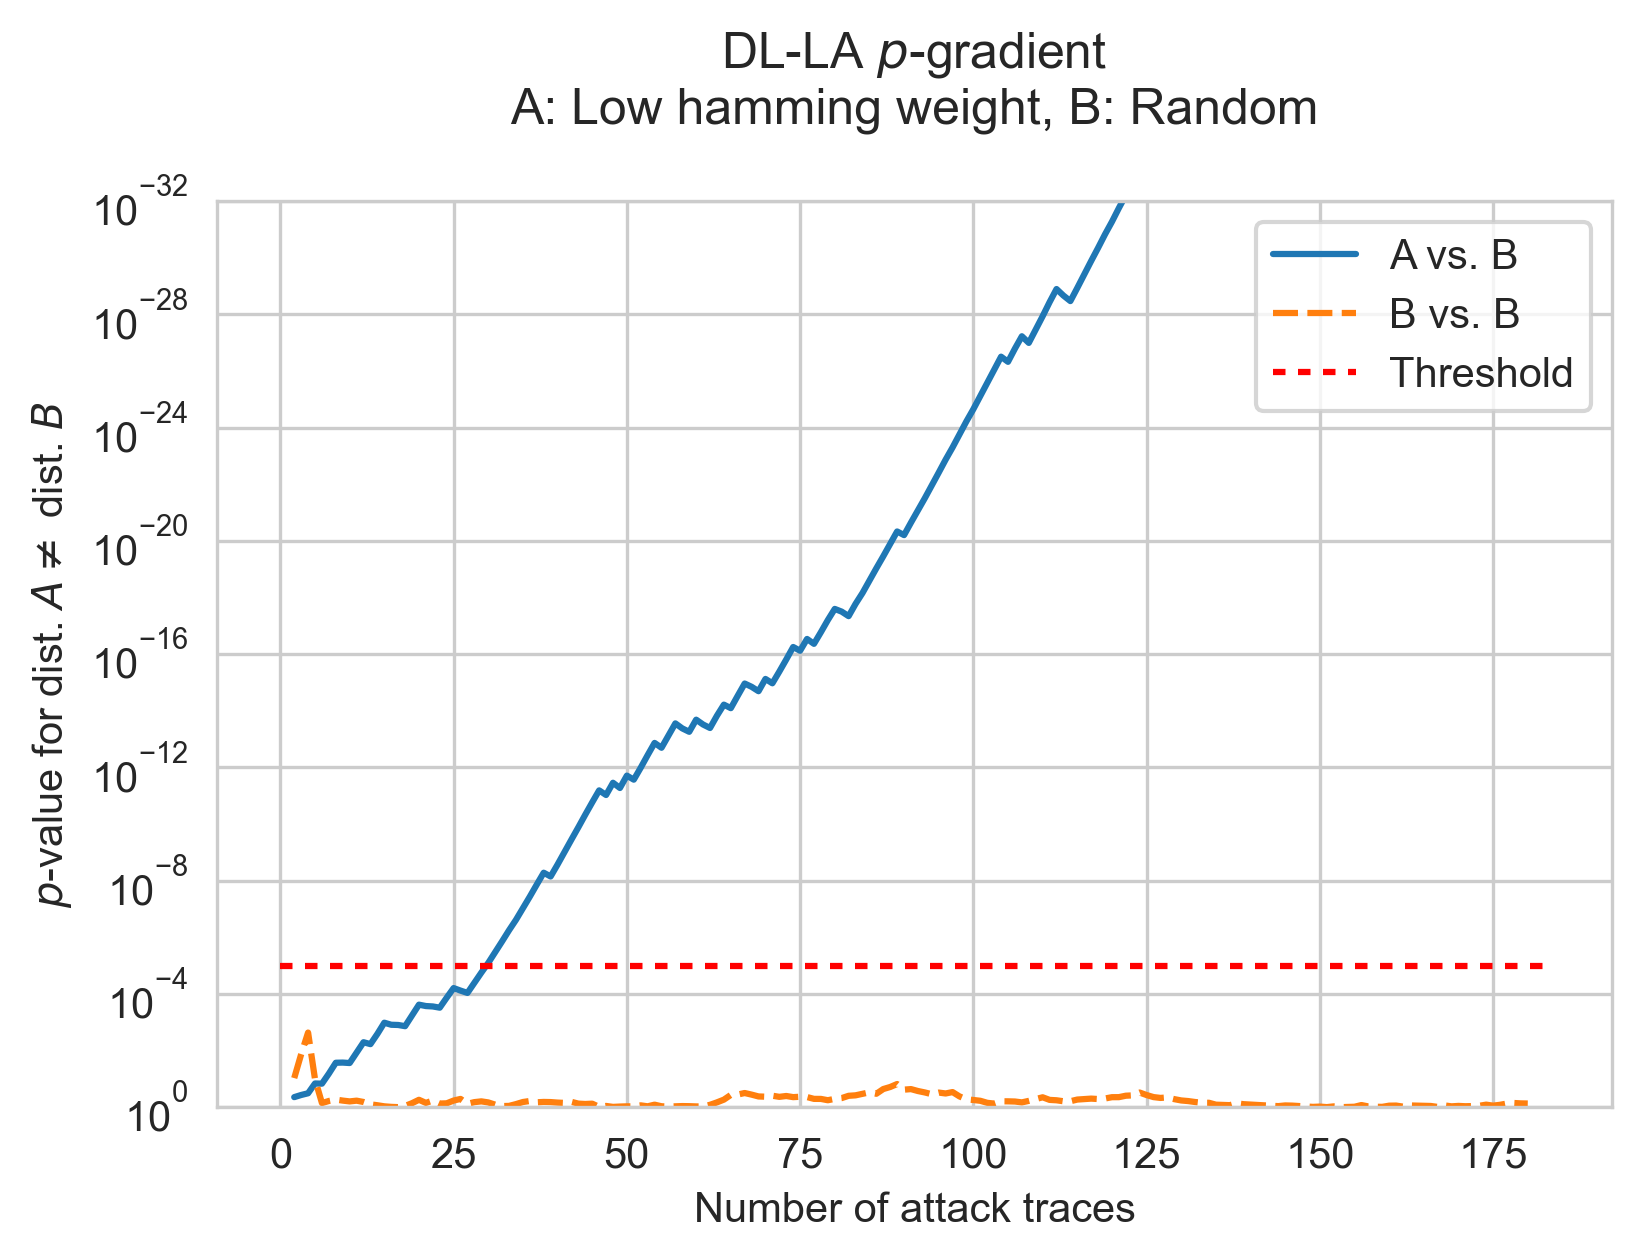

In [21]:
plot_p_gradient({"A vs. B": AB_PG["A vs. B"], "B vs. B": BB_PG["A vs. B"]}, f"DL-LA $p$-gradient\n{TITLE}", 1000)

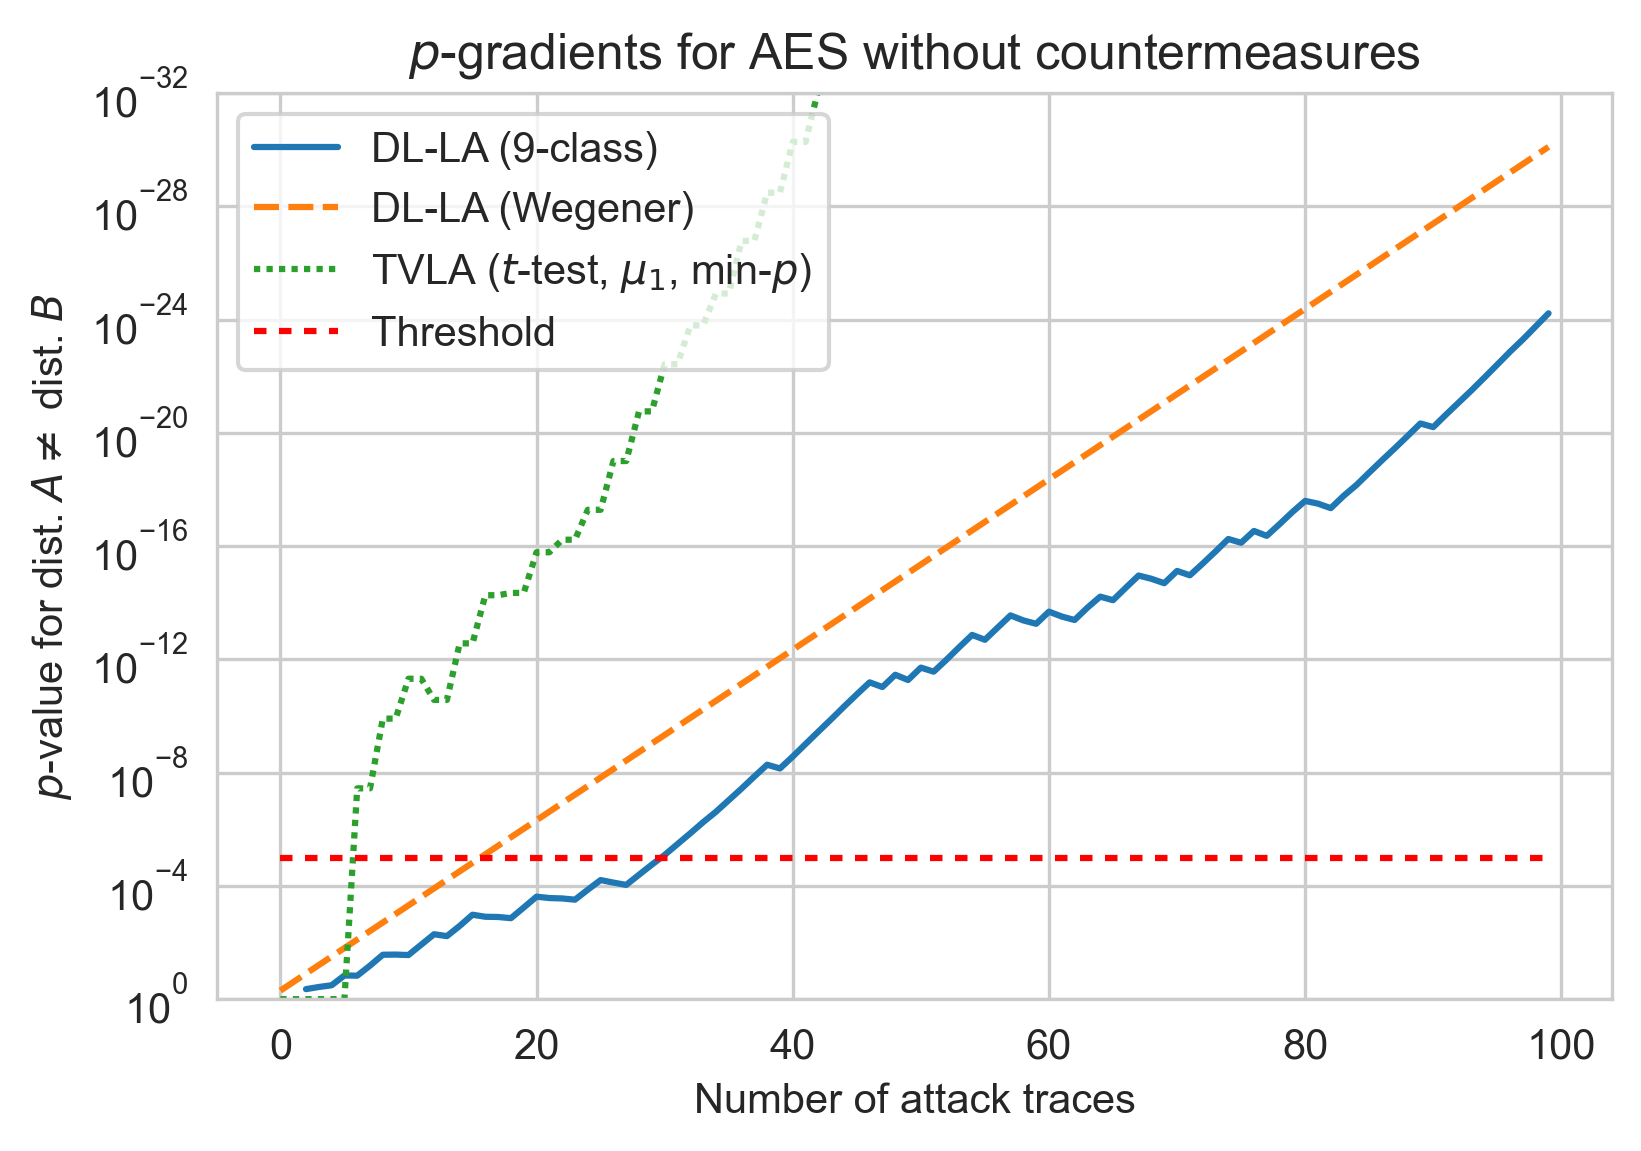

/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,A vs. B,A vs. A
0,NaN,NaN
1,NaN,NaN
2,4.981198e-02,0.389129
3,2.043155e-03,0.153732
4,8.521107e-07,0.900498
...,...,...
179,2.599106e-54,0.641694
180,8.041447e-55,0.641265
181,2.416324e-55,0.625956
182,7.822478e-56,0.634244


In [22]:
plot_p_gradient({"DL-LA (9-class)": AB_PG["A vs. B"],
                 "DL-LA (Wegener)": AB_PG_WEGENER,
                 "TVLA ($t$-test, $\mu_1$, min-$p$)": ACC_AB.p_gradient(1), },
                f"$p$-gradients for AES without countermeasures", MAX_TRACES,
                file_name="aisy-all")

dlla_p_gradient(MODEL_AB, *AB_DLLA[2:])

In [ ]:
def do_jitter(param):
    return jitter(TRACES, param)

In [ ]:
ACCU = []
for JITTER_AMOUNT in ['0']:
    JITTER_NUM = float(JITTER_AMOUNT.replace("-", "."))

    JITTER_TRACES = TRACES

    def dlla9_performance(traces, hw):
        """
        Labels and z-normalizes traces, trains a MLP (as shown in the DL-LA paper).
        Returns the p-gradient for the attack traces
        """
        trc, _ = prepare_dlla_9cls(traces, hw)
        model = make_mlp(*trc[:2])

        return dlla_p_gradient(model, *trc[2:])

    # DLLA_9_JITTER = dlla9_performance(JITTER_TRACES, HAMMING_WEIGHTS)

    A_JITTER, B_JITTER = JITTER_TRACES[TVLA_BYTE], JITTER_TRACES[np.invert(TVLA_BYTE)]
    TVLA_JITTER = min_p_gradient(A_JITTER[:2000], B_JITTER[:2000])[1]
    DLLA_2_JITTER = wegener_performance(A_JITTER, B_JITTER)

    ACCU.append((np.argmax(TVLA_JITTER < 10 ** -5), np.argmax(DLLA_2_JITTER < 10 ** -5)))

    print(ACCU)

    plot_p_gradient({
        # "DL-LA (9-class)": DLLA_9_JITTER["A vs. B"],
        "DL-LA (Wegener)": DLLA_2_JITTER,
        f"TVLA ($t$-test, $\mu_1$, min-$p$)": TVLA_JITTER,
    }, f"$p$-gradients for unprotected AES, jitter $\lambda = {JITTER_NUM}$", 2000,
    file_name=f"aisy-all-jitter-{JITTER_AMOUNT}")

ACCU

In [ ]:
EX_LAMBDA = 15

G = sns.lineplot(data={
    "Trace without jitter": TRACES[0],
    f"Trace with jitter, $\lambda = {EX_LAMBDA}$": jitter([TRACES[0]], 2.5)[0]
})
G.set(title="Jitter example",
      ylabel="Power level",
      xlabel="Sample point",
      xlim=(0,500), ylim=(0, 125)) and None
[l.set_linestyle('-') for l in G.lines]
G.legend()

In [ ]:
sns.lineplot(data={
    "Moment difference, no jitter": mdiff(A5, B5),
    f"Moment difference, jitter $\lambda = {EX_LAMBDA}$": mdiff(cache_np(f"aisy/jitter/{EX_LAMBDA}/a5"), cache_np(f"aisy/jitter/{EX_LAMBDA}/b5"))
})
